The report part of this homework should be done on a word document or pdf only!

You may work in groups to discuss the problems and work through solutions together. However, you must write up your solutions on your own, without copying another student's work or letting another student copy your work. In your solution for each problem, you must write down the names of your partner (if any); this will not affect your grade. Plagiarism is not tolerated.

# **Question 1 : Clustering for Image segmentation**

For this question, we spectral clustering to an image. The goal is to perform image segmentation. Image segmentation is the process of partitioning an image into multiple segments or sets of pixels. The purpose of segmentation is to simplify or change the representation of an image into something that is more meaningful and easier to analyze. Spectral clustering can be **computationally expensive for large images** because it requires the computation of the eigenvalues and eigenvectors of the similarity matrix. Therefore, it's more commonly used for smaller images or after pre-processing steps that reduce the size of the image or the number of features.

In this homework you will perform image segmentation under the following context:

Image Segmentation with Spectral Clustering: Spectral clustering is being used to segment the image based on the similarity of pixels in terms of color, intensity, or texture. The algorithm considers the image as a graph, where each pixel is a node and the edges represent the similarity between pixels. It aims to group pixels that are similar to each other into the same clusters, effectively segmenting the image into different regions.

**The Process**: The segmentation process with spectral clustering typically involves the following steps:

*   Reshaping the image into a feature array where each pixel is represented by its RGB values.
*   Applying the spectral clustering algorithm to this array to group similar pixels together.
*   Reshaping the resulting labels back into the original image dimensions to visualize the segments.

The Result: The output is a labeled image where each pixel has been assigned a cluster label, and pixels with the same label belong to the same segment. This can be used to identify distinct regions, objects, or textures within the image.

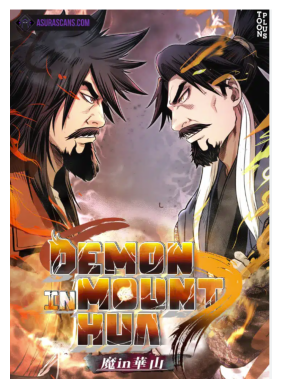

In [ ]:
import numpy as np
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
from PIL import Image

# Load the image using PIL
image = Image.open("Demon_in_mount_hua.png")

# Convert the image to an array
image_array = np.array(image)

# Get the dimensions of the image
width, height = image.size

# Convert the image to an array
image_array = np.array(image)

# Display the original image
plt.imshow(image_array)
plt.axis('off')  # Hide axis labels
plt.show()

The similarity matrix computation can be computationally expensive, especially for large datasets such as images where each pixel becomes a data point. When you compute the pairwise distances between all pairs of pixels in an image, the size of the similarity matrix grows quadratically with the number of pixels, which can quickly become infeasible for large images. We need to downsample the image to reduce the resolution of the image before processing. This significantly reduces the number of data points (pixels) and makes the computation more manageable.

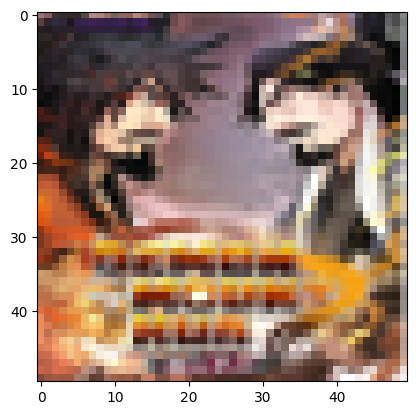

In [ ]:
# Downsample the image for less computational load
image_small = image.resize((50, 50))  # Example size, adjust as needed

# Convert the image to grayscale and then to an array
image_small_gray = image_small.convert('L')
image_array_small = np.array(image_small_gray).reshape(-1,1)

# Flatten the image to create a 2D array
flattened_image_array = image_array_small.flatten().reshape(-1, 1)
plt.imshow(image_small)

**Question one Part A: Constructing the similarity matrix**
To create a detailed similarity matrix and subsequently derive the eigenvectors and eigenvalues for spectral clustering, you would typically follow these steps:

Define the Similarity Function: This is usually an exponential function of the negative Euclidean distance between data points, scaled by a parameter
γ, such as the Gaussian kernel:A[i][j] = exp (-γ.∥xi - xj∥ ^ 2)
Create the Similarity Matrix: For all pairs of data points, compute the similarity and form a matrix A.

Construct the Laplacian Matrix: The Laplacian matrix L is calculated from the similarity matrix A and the degree matrix D, which is a diagonal matrix where each entry D[i][i] is the sum of the i-th row of A.

Compute Eigenvalues and Eigenvectors: The eigenvalues and eigenvectors of L are computed to find the best representation of the data points in a lower-dimensional space that respects the clusters.

Lets get right into it!
Complete the codes!

In [ ]:
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import numpy as np
# Step 1: Define the Similarity Function (Gaussian Kernel)
def similarity_function(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

# Step 2: Create the Similarity Matrix - now in a more efficient manner
def create_similarity_matrix(data, gamma):
    # Compute the pairwise squared Euclidean distances and then the similarity matrix in one go
    n = len(data)
    distances = pdist(data, metric='euclidean')
    sq_distances = squareform(distances) ** 2
    similarity_matrix = np.exp(-gamma * sq_distances)

    return similarity_matrix

    # Compute the pairwise squared Euclidean distances and then apply the similarity function
    for i in range(n):
        for j in range(i, n):  # Only compute the upper triangular part to save computation
            sq_distance = np.linalg.norm(data[i] - data[j]) ** 2
            similarity_matrix[i, j] = similarity_function(data[i],data[j], gamma)
            similarity_matrix[j, i] = similarity_function(data[j],data[i], gamma)  # Similarity matrix is symmetric

    return similarity_matrix

# Step 3: Construct the Sparse Laplacian Matrix
def construct_sparse_laplacian_matrix(similarity_matrix):
    # Degree matrix
    degree_matrix = np.diag(similarity_matrix.sum(axis=1))

    # Sparse degree matrix
    D_sparse = csr_matrix(degree_matrix)

    # Sparse similarity matrix
    A_sparse = csr_matrix(similarity_matrix)

    # Sparse Laplacian
    L_sparse = D_sparse - A_sparse
    return L_sparse


# Step 4: Compute Eigenvalues and Eigenvectors
gamma = 0.1  # Adjust this parameter based on your data
data = flattened_image_array
similarity_matrix = create_similarity_matrix(data, gamma)
laplacian_matrix = construct_sparse_laplacian_matrix(similarity_matrix)


# Compute the eigenvalues and eigenvectors using the sparse solver
# We'll compute the k smallest eigenvalues/eigenvectors
k = 3  # Number of clusters/eigenvectors to find
eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=k+1, which='SM')

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Choose the number of clusters (k) based on eigenvalues
k = 3  # Adjust this based on your data
selected_eigenvectors = eigenvectors[:, :k]

**Question one Part B Understanding Silhouette Coefficient**

Bonus point, just run the code as is

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Use KMeans to cluster the data points based on the eigenvectors
n_clusters = 2  # Assume the desired number of clusters is 2
labels = KMeans(n_clusters=n_clusters).fit_predict(eigenvectors)

# Calculate the silhouette score
silhouette_avg = silhouette_score(similarity_matrix, labels)
print(f"Silhouette score: {silhouette_avg}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score: -0.13216013917865974


# **Question one Part B Creating the Spectral Clustering Algorithm**

In [ ]:
from sklearn.model_selection import ParameterGrid

def spectral_clustering(data, n_clusters, gamma):
    # Create the similarity matrix
    similarity_matrix = create_similarity_matrix(data, gamma)

    # Construct the sparse Laplacian matrix
    laplacian_matrix = construct_sparse_laplacian_matrix(similarity_matrix) #complete this section

    k = int(n_clusters) + 10  # Ensure k is an integer

    # Compute the eigenvalues and eigenvectors using the sparse solver
    eigenvalues, eigenvectors = eigsh(laplacian_matrix, k = k+1, which='SM' )

    # Ensure n_clusters is an integer
    n_clusters = 3
    start_idx = 1 if np.isclose(eigenvalues[0], 0) else 0
    selected_eigenvectors = eigenvectors[:, start_idx:start_idx + n_clusters]

    # Ensure we have enough eigenvectors for clustering
    if selected_eigenvectors.shape[1] < n_clusters:
        raise ValueError("Insufficient eigenvectors for clustering. Increase the number of eigenvalues requested.")

    # Perform KMeans clustering
    labels = KMeans(n_clusters = n_clusters).fit_predict(eigenvectors)

    # Calculate and return the labels and silhouette score
    silhouette_avg = silhouette_score(similarity_matrix, labels)
    return labels, silhouette_avg
# Define a range of gamma values to try
gamma_values = np.logspace(-2, 1, 10)  # Example range
param_grid = {'gamma' : gamma_values}

n_clusters = 2  # Example number of clusters

# Find the best gamma parameter
best_params = None
best_score = -1

for params in ParameterGrid(param_grid):
    gamma = params['gamma']
    _, silhouette_avg = spectral_clustering(flattened_image_array, gamma, n_clusters)  # Unpack the tuple
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params

print(f"Best gamma: {best_params['gamma']} with silhouette score: {best_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Best gamma: 4.6415888336127775 with silhouette score: 0.009741939700144638


# **Question one Part C Comparing the Spectral clustering with K means on a sample dataset**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


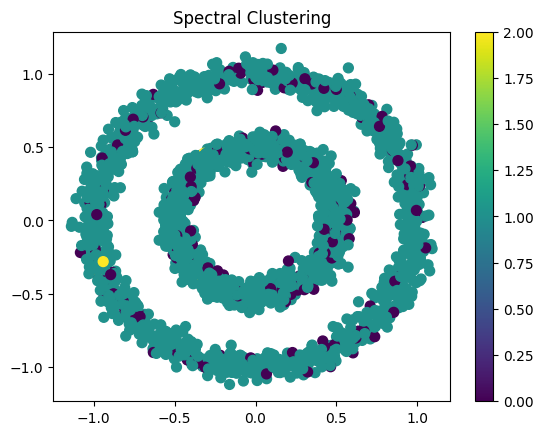

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.3901882884271845


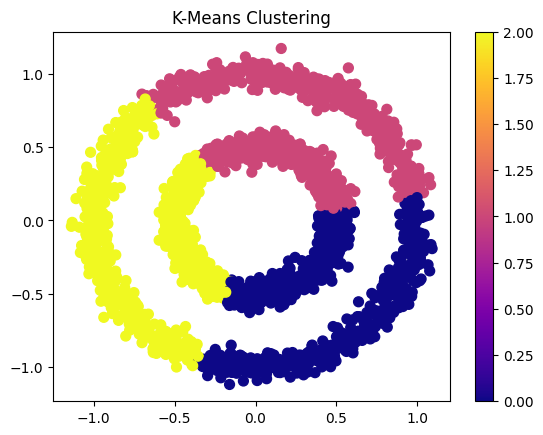

In [ ]:
from sklearn import datasets

#Apply spectral clustering with the best gamma
#Generate sample data (As we defined the image size 50X50, n_samples=1500 will give an error)
x, _ = datasets.make_circles(n_samples=2500, factor=.5, noise=.05)

# Apply spectral clustering with best gamma
n_clusters = 3
labels, silhouette_avg = spectral_clustering(image_array_small, gamma, n_clusters)
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap='viridis')
ax.set_title('Spectral Clustering')
plt.colorbar(scatter)
plt.show()

#Create a simple K-means and apply to the sample dataset
# Specify the number of clusters (should be the same 'k' used in spectral clustering above)
n_clusters = 3

# Create KMeans instance
kmeans = KMeans(n_clusters = n_clusters)

# Fit the model and get labels (Changed the KMeans to kmeans, it was giving error for missing 1 arguement)
labels = kmeans.fit_predict(x)

# Plot the clusters
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap='plasma')
ax.set_title('K-Means Clustering')
plt.colorbar(scatter)

# Calculate silhouette score
silhouette_avg = silhouette_score(x, labels)
print("Silhouette Score:", silhouette_avg)

plt.show()

# **Question 1 PART D: Which clustering technique performed better?**

In this case, it's better to define the spectral clustering using the kmeans clustering approach by observing the colorbar. The reason for this is that kmeans clustering provides a clear partitioning of the data into clusters based on the similarity of their data points.

KMeans clustering technique performed better.

# **Question one Part E Applying K-means to the comic image**

Fitting model on a small sub-sample of the data
(1379248, 1)
(698, 494, 4)
(2500, 1)
(2500, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done in 5.493s.
Predicting color indices on the full image (k-means)
done in 0.046s.


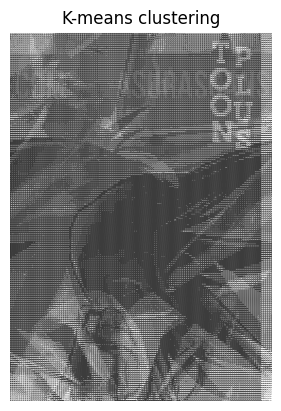

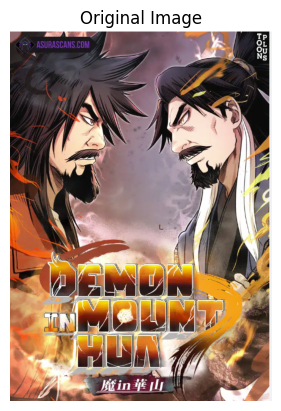

In [ ]:
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn import preprocessing
from time import time

n_colors = 3


print("Fitting model on a small sub-sample of the data")
t0 = time()
height, width, channels = image_array.shape
image_array_2d = image_array.reshape(-1,1)
print(image_array_2d.shape)
print(image_array.shape)
print(image_array_small.shape)
print(flattened_image_array.shape)
kmeans = KMeans(n_clusters = n_colors, random_state = 42)
kmeans.fit(image_array_2d)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array_2d)
print("done in %0.3fs." % (time() - t0))


def recreate_image(labels, w, h):
    """Recreate the (compressed) image from the labels"""
    image = np.zeros((h, w))  # Note: NumPy arrays are in row-major order, so it's height x width
    label_idx = 0
    for i in range(h):  # Iterate over height (rows)
        for j in range(w):  # Iterate over width (columns)
            if label_idx < len(labels):  # Check to avoid IndexError
                image[i][j] = kmeans.cluster_centers_[labels[label_idx]]
                label_idx += 1
    return image


# Recreate the segmented image
recreated_image = recreate_image(labels, width, height)

# Show the segmented image
plt.imshow(recreated_image, cmap='gray')
plt.axis('off')
plt.title('K-means clustering')
plt.show()

# Display the original image
plt.imshow(image_array)
plt.axis('off')  # Hide axis labels
plt.title('Original Image')
plt.show()

# **Question 1 Part F : Applying Spectral clustering to the image**

Note that this portion will take a while to run because it is computationally expensive.

In [ ]:
image_array = (image_array - np.min(image_array))/(np.max(image_array) - np.min(image_array))
a = image_array.reshape(-1,1)
a.shape

(1379248, 1)